# Analysis for project 1

Use this notebook to experiment with preprocessing and embedding steps. Ultimately moved to `embed.py`

In [1]:
import numpy as np
import pandas as pd
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# import embedding functions
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from umap import UMAP

from embed import read_tcga, normalize

/raidixshare_log-g/mcuoco/projects/ece204_project1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read and clean the data

In [2]:
adata = read_tcga()

Reading data/TCGA.HNSC.expression.txt...
Reading data/TCGA.HNSC.metadata.txt...
Cleaning metadata...
Creating AnnData object...


We have 545 samples from 500 patients. 20531 features (genes) were quantified from each sample

## Inspect mean-variance relationship of features

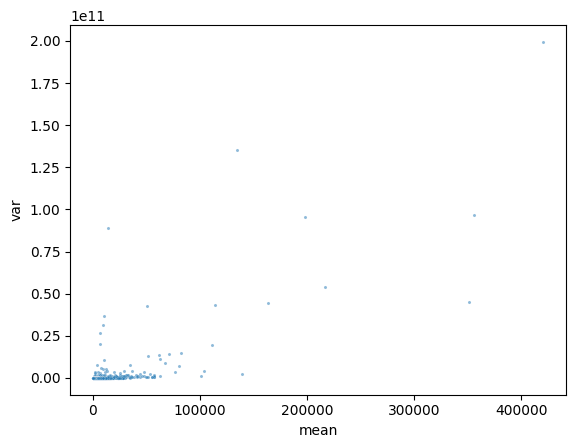

In [3]:
mean_var = pd.DataFrame()
mean_var['mean'] = adata.X.mean(axis=0)
mean_var['var'] = adata.X.var(axis=0)
f = sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)

[None, None]

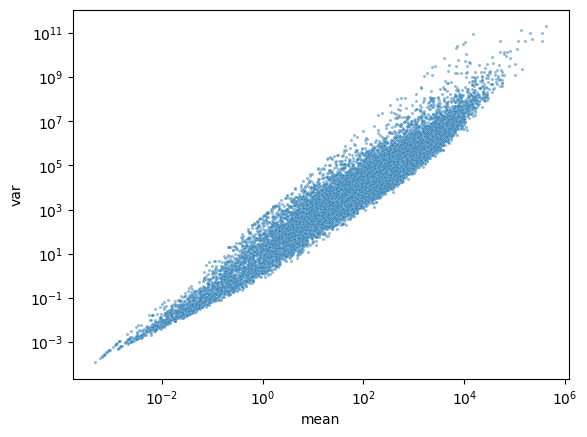

In [4]:
# log transform axes to see more clearly
f = sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)
f.set(xscale="log", yscale="log")

Data is heteroscedastic. We will need to stabilize the variance of the data before proceeding.

<Axes: xlabel='mean', ylabel='var'>

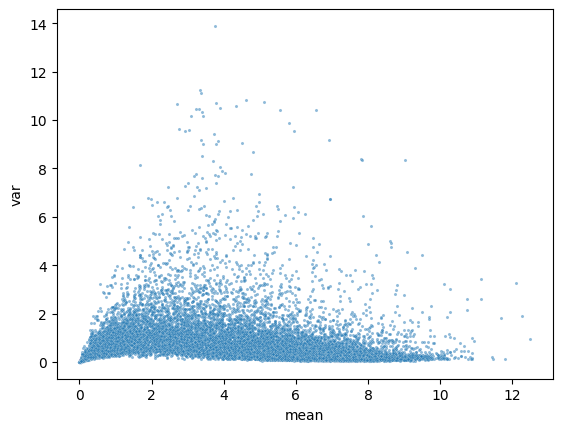

In [5]:
# log1p transform expression data (can't use log because of zeros)
expr_norm = pd.DataFrame(np.log1p(adata.X))
mean_var['mean'] = expr_norm.mean(axis=0)
mean_var['var'] = expr_norm.var(axis=0)
sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)

## Normalize, scale, center, and embed the data

In [6]:
adata = normalize(adata)

Removing unexpressed genes...
Log transforming...
Scaling and centering...


In [ ]:
from jackstraw.permutationPA import permutationPA
rest, pval = permutationPA(adata.X)

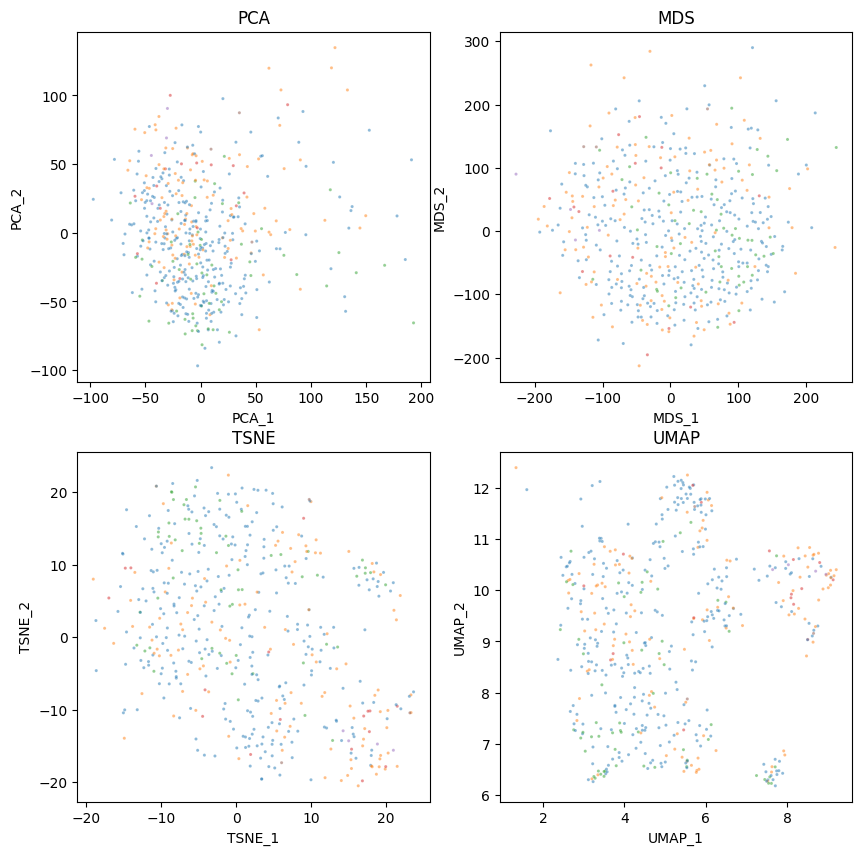

In [20]:
# setup 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, method in enumerate(['pca', 'mds', 'tsne', 'umap']):
	if method == 'pca':
		# get embedding
		adata.obsm[method] = PCA().fit_transform(adata.X)
	elif method == 'mds':
		# get embedding
		adata.obsm[method] = MDS(normalized_stress='auto').fit_transform(adata.X)
	elif method == 'tsne':
		# get embedding
		adata.obsm[method] = TSNE().fit_transform(adata.obsm["pca"][:,:rest])
	elif method == 'umap':
		# get embedding
		adata.obsm[method] = UMAP().fit_transform(adata.obsm["pca"][:,:rest])

	# plot embedding
	sns.scatterplot(x=adata.obsm[method][:,0], y=adata.obsm[method][:,1], s=5, alpha=0.5, hue=adata.obs['histological_grade'], ax=axs[int(i/2), i%2])
	method = method.upper()
	axs[int(i/2), i%2].set_title(method)
	axs[int(i/2), i%2].set(xlabel=method+'_1', ylabel=method+'_2')

	# hide legend
	axs[int(i/2), i%2].legend_.remove()